# Functional Connectivity

- **Created:** November 2024 by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) 
- **conda environment**: Needs the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

## Beta-series regression

Let's load up the single-trial Betas from 

## Getting Ready

As usual, we need some python packages like below:

In [147]:
import numpy as np              # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab
import seaborn as sns           # This provides another popular set of plotting functions
import pandas as pd             # To use "dataframes" (like tables in Matlab)
import os                       # To interact with the operating system, including files and paths (e.g. path.join)
import time                     # To use "time" (like "tic" in Matlab)

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
import nilearn as nl           # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import datasets    # includes e.g. fetch_atlas_harvard_oxford
from nilearn import masking
from nilearn import input_data  # includes NiftiMasker, NiftiLabelsMasker
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import decoding    # includes Searchlight
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.glm.first_level import FirstLevelModel, compute_regressor, spm_hrf
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.maskers import NiftiMasker, NiftiSpheresMasker

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

from scipy.stats import pearsonr
%matplotlib inline

functional connectivity, task-based connectivity (beta-series regression), effective connectivity (DCM)

In [ ]:
wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
os.chdir(wd)
print(f"Working directory currently {os.getcwd()}")

# where the beta images were saved from nb08, which we need for beta series regression
mvpa_dir = os.path.join(wd, 'mvpa')

In [ ]:
fmri_data_dir = 'data' # data in BIDS format
fmri_results_dir = 'results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)
# Attach the results folder to the layout. 
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))

In [276]:
sID = '15'

events_files = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print("Found " + str(len(events_files)) + " event files")

model_name = 'LSA_2FF_2SF' 
outdir = os.path.join(mvpa_dir, model_name, 'sub-' + sID)

conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
conditions_of_interest = ['IniFF', 'DelFF', 'IniSF', 'DelSF']
other_conditions = [val for val in conditions if val not in conditions_of_interest]

img_4d_fname = []
trial_labels = []
for run, events_file in enumerate(events_files):
    trial_beta_file = os.path.join(outdir, os.path.basename(events_file).split("events")[0] + model_name + '_betas.nii.gz')
    print(trial_beta_file)
    img_4d_fname.append(trial_beta_file)

    events_df = pd.read_table(events_file)
    trials_to_save = events_df["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    trials_to_save = [label[3:5] for label in trials_to_save]
    trial_labels.extend(trials_to_save)

#print(labels_per_run)

Found 9 event files
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-1

### ROI to ROI

Let's define again the functional fusiform ROI and the anatomical amygdala ROI

In [269]:
amyg_ROI = nib.load(os.path.join(fmri_results_dir,'amygdala_mask.nii.gz'))
print(amyg_ROI.get_fdata().shape)
amyg_ROI = nl.image.resample_to_img(amyg_ROI, img_4d_fname[0], interpolation='nearest') # resample ROI to bold resolution to save time when estimating glm below
print(amyg_ROI.get_fdata().shape)

fusi_ROI = nib.load(os.path.join(fmri_results_dir,'sphere_and_faces-scrambled_Zmap_fdr.nii.gz'))
# shouldn't need to resample fusi ROI, but just to be safe!
fusi_ROI = nl.image.resample_to_img(fusi_ROI, img_4d_fname[0], interpolation='nearest') 

amyg_masker = nl.input_data.NiftiMasker(amyg_ROI)
fusi_masker = nl.input_data.NiftiMasker(fusi_ROI)

(64, 76, 64)
(97, 115, 97)


In [79]:
fusi_data_per_run = []
amyg_data_per_run = []
for run in range(len(img_4d_fname)):
    print(img_4d_fname[run])
    
    fusi_data = fusi_masker.fit_transform(img_4d_fname[run])
    fusi_data = np.mean(fusi_data, axis=1) # average across voxels
    fusi_data_per_run.append(fusi_data)

    amyg_data = amyg_masker.fit_transform(img_4d_fname[run])
    amyg_data = np.mean(amyg_data, axis=1) # average across voxels
    amyg_data_per_run.append(amyg_data)

fusi_data = np.concatenate(fusi_data_per_run, axis=0)
amyg_data = np.concatenate(amyg_data_per_run, axis=0)
print(fusi_data.shape)

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_tas

In [113]:
trials_per_condition = []
conditions = list(set(trial_labels))
for con, condition in enumerate(conditions):
    trials_per_condition.append([i for i, x in enumerate(trial_labels) if x == condition])
    print(f'{len(trials_per_condition[con])} {condition} trials')

202 SF trials
212 FF trials


<Figure size 640x480 with 0 Axes>

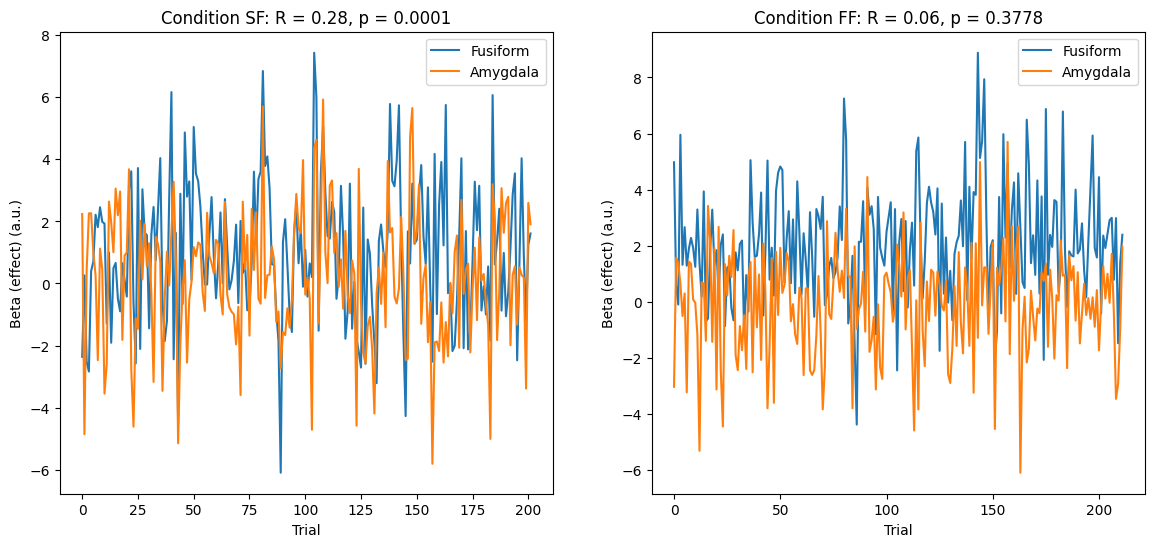

In [213]:
plt.figure(); 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6));

Rval_data = []
for ax in range(len(axs.flat)):
    axs[ax].plot(fusi_data[trials_per_condition[ax]]);
    axs[ax].plot(amyg_data[trials_per_condition[ax]]);
#    axs[ax].plot(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]],'o');
    axs[ax].set_xlabel('Trial');
    axs[ax].set_ylabel('Beta (effect) (a.u.)');
    axs[ax].legend(['Fusiform', 'Amygdala']);
    pcor = pearsonr(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]])
    axs[ax].set_title('Condition ' + conditions[ax] + ": R = " + str(round(pcor.statistic,2)) + ", p = " + str(round(pcor.pvalue,4)));
    Rval_data.append(pcor.statistic)

To test whether this difference in functional connectivity between fusiform and amygdala ROs for famous (FF) and scrambled (SF) faces is significant, we can use a permutation test to estimate the probability of getting such a difference in correlations under the null:

Permuted p-value for difference in Z-values being as big as 0.21 is 0.016


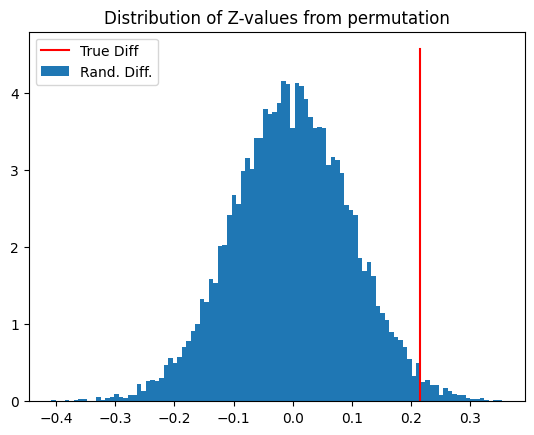

In [268]:
num_rand = int(1e4) # Number of randomisations
Rval = np.empty([len(conditions),num_rand])
for con, condition in enumerate(conditions):
    fusi_samp = fusi_data[trials_per_condition[con]]
    
    for r in range(num_rand):
        amyg_perm = np.random.permutation(amyg_data[trials_per_condition[con]])
        pcor = pearsonr(fusi_samp, amyg_perm)
        Rval[con,r] = pcor.statistic

Rval_dif_data = Rval_data[0] - Rval_data[1]
Rval_dif_perm = Rval[0,:] - Rval[1,:]

pdf, bin_edges = np.histogram(Rval_dif_perm, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.plot([Rval_dif_data, Rval_dif_data], [0, 1.1*np.max(pdf)], 'r-')
plt.title('Distribution of difference in R values from permutation'); plt.legend(['True Diff', 'Rand. Diff.']);

pval = (np.sum(np.abs(Rval_dif_perm) >= np.abs(Rval_dif_data)) + 1) / (2*num_rand + 1)
print(f'Permuted p-value for difference in R values being as big as {round(Rval_dif_data,2)} is {round(pval,3)}')

In [267]:
# Alternative Fisher test between two independent correlations
# Convert to Z-values using Fisher transform (atanh)
difZ = np.arctanh(Rval_data[0]) - np.arctanh(Rval_data[1])
# Fisher test given number of observations in each condition
Zdif = difZ / np.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) 
#two-tailed
pval = scipy.stats.norm.cdf(-abs(Zdif)) + 1-scipy.stats.norm.cdf(abs(Zdif))
print(f'Permuted p-value for difference in Z-values being as big as {round(difZ,2)} is {round(pval,3)}')

Permuted p-value for difference in Z-values being as big as 0.22 is 0.025


univariate connectivity - multivariate connectivity do exist, where do not average across voxels (review)

### ROI to whole brain

Let's map out connectivity across brain

In [237]:
brain_masker = NiftiMasker(smoothing_fwhm=10)

brain_data_per_run = []
for run in range(len(img_4d_fname)):
    print(img_4d_fname[run])
    brain_data = brain_masker.fit_transform(img_4d_fname[run])
    brain_data_per_run.append(brain_data)
    
brain_data = np.concatenate(brain_data_per_run, axis=0)
print(brain_data.shape)

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_tas

In [238]:
indices = trials_per_condition[0] # conditions[0]
brain_corrs_con1 = np.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con1 = brain_corrs_con1 / (np.linalg.norm(fusi_data[indices]) * np.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con1 = np.arctanh(brain_corrs_con1) # Fisher Transform R value to Z value

indices = trials_per_condition[1] # conditions[1]
brain_corrs_con2 = np.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con2 = brain_corrs_con2 / (np.linalg.norm(fusi_data[indices]) * np.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con2 = np.arctanh(brain_corrs_con2) # Fisher Transform R value to Z value

In [265]:
difZ = np.arctanh(brain_corrs_con2) - np.arctanh(brain_corrs_con1) # 2-1 for Faces > Scrambled
Zdif = difZ / np.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) # Fisher method for comparing two independent correlations
#two-tailed
pval = scipy.stats.norm.cdf(-abs(Zdif)) + 1-scipy.stats.norm.cdf(abs(Zdif))

# Determine p-value from same null used above - not strictly correct since assumes null from amygdala ROI same for all voxels
# Rval_dif_data = brain_corrs_con2 - brain_corrs_con1
# pval = np.empty([len(Rval_dif_data)])
# for v in range(len(Rval_dif_data)):
#     pval[v] = (np.sum(np.abs(Rval_dif_perm) >= np.abs(Rval_dif_data[v])) + 1) / (2*num_rand + 1)
# sval = np.sign(Rval_dif_data)

sval = np.sign(difZ)
pval = sval * -np.log10(pval)

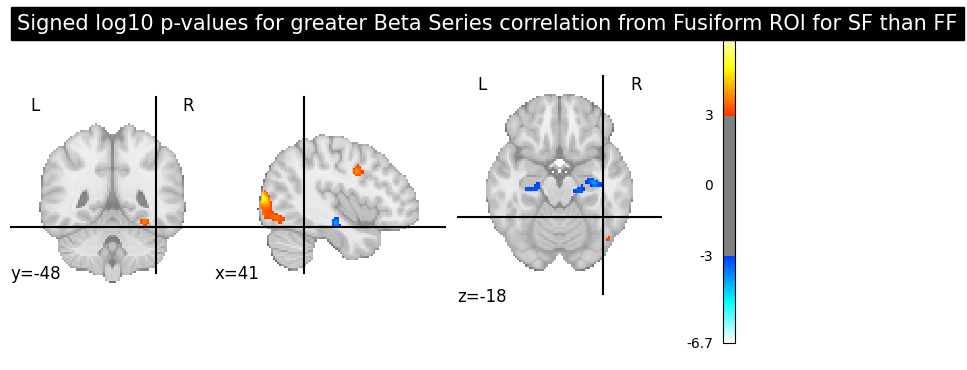

In [266]:
brain_diff_con_img = brain_masker.inverse_transform(pval)
fusi_coords = (41.5, -48.5, -18.5) # from nb06
display = plotting.plot_stat_map(brain_diff_con_img, cut_coords=fusi_coords, threshold = -np.log10(0.001),
    title="Signed log10 p-values for greater Beta Series correlation from Fusiform ROI for " + conditions[1] + " than " + conditions[0])

## Functional connectivity from task residuals

Finally, we will do some analyses similar to what you might do for resting-state fMRI, ie correlations between the original fMRI timeseries. Unfortunately this dataset does not have a proper resting-state run, but we can estimate this by removing (as best as possible) the effects of the task. The resulting timeseries reflect whatever is happening during the times between trials (note that there are short periods of rest between blocks of trials in this design).

First let's load the raw fMRI volumes for the current subject, and recreate their design matrix

In [312]:
fcon_out = os.path.join(wd, 'fcon')
if not os.path.exists(fcon_out):
    os.makedirs(fcon_out)
print(f"Output directory {fcon_out}")

Output directory /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/fcon


In [355]:
bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename')
nvols = nib.load(bold[0]).shape[-1] # assume same for all runs
print(f"Found {nvols} preprocessed functional files (dfs) for each of {len(bold)} runs")

Found 208 preprocessed functional files (dfs) for each of 9 runs


### Confounds and expansion of motion parameters

We'll get the confounds again, but this time we will use some more, since very important for functional connectivity based on fMRI timeseries. We'll use the "Sattherthwaite 24" expansion of motion parameters into their finite differences, squares and difference squares, to capture delayed and nonlinear dependencies of the BOLD signal on motion.

All this are already in the confounds file, but we will recreate them for clarity


In [309]:
confound_files = layout.get(subject = sID, datatype = 'func', desc = 'confounds', extension = ".tsv", return_type = 'filename')
motion_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
other_confounds  = ['csf', 'white_matter']

confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pd.read_table(conf_file)
    motion_subset = this_conf[motion_confounds].fillna(0) # replace NaN with 0
    motion_change = motion_subset.diff().fillna(0)
    motion_change.columns = 'diff_' + motion_subset.columns
    motion_square = motion_subset.pow(2)
    motion_square.columns = 'sq_' + motion_subset.columns 
    motion_change_square.columns = 'sq_' + motion_change.columns
    motion_24 = pd.concat([motion_subset, motion_change, motion_square, motion_change_square], axis=1)
    confounds = pd.concat([motion_24, this_conf[other_confounds].fillna(0)], axis=1)
    confounds = (confounds - confounds.mean())/(confounds.std()) # Z-score just for visualisation
    confounds_for_glm.append(confounds)
    
print(f"Using around {confounds_for_glm[0].shape[1]} dfs per run to remove motion, CSF and WM effects")
confounds_for_glm[0].head()

Using around 26 dfs per run to remove motion, CSF and WM effects


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,diff_trans_x,diff_trans_y,diff_trans_z,diff_rot_x,...,sq_rot_y,sq_rot_z,sq_diff_trans_x,sq_diff_trans_y,sq_diff_trans_z,sq_diff_rot_x,sq_diff_rot_y,sq_diff_rot_z,csf,white_matter
0,-2.663965,-0.050465,1.646214,-2.270807,-0.105551,1.606538,-0.040756,0.011890,0.104907,-0.023776,...,-0.563781,-1.048875,-0.520897,-0.822966,-0.734843,-0.566957,-0.549476,-0.64080,1.427270,-1.927881
1,-2.089276,-0.050730,1.633572,-2.308108,-0.951504,1.524627,0.967426,0.011654,0.033503,-0.087451,...,0.268023,-1.059692,-0.041947,-0.690097,-0.711682,0.347263,0.473843,-0.31298,-0.243501,-1.408297
2,-2.089388,0.506916,1.398660,-2.554022,-1.073953,1.604675,-0.040954,0.508596,-1.221889,-0.443568,...,0.460676,-1.049175,-0.432199,-0.807755,-0.723394,-0.110665,1.410447,-0.64080,-1.626780,-1.233026
3,-2.321569,1.279277,1.653771,-2.868098,-1.562653,1.646782,-0.448073,0.699848,1.545787,-0.559923,...,1.411538,-1.041760,-0.432347,-0.812445,0.247171,0.020090,1.422519,-0.64080,-0.872037,-1.262264
4,-2.929160,-0.049992,1.548451,-2.383782,-2.160815,1.581369,-1.106658,-1.172116,-0.489947,0.802983,...,2.971501,-1.052721,0.406711,-0.663088,-0.693053,-0.425240,-0.524634,-0.64080,-1.093800,-1.082579


### Global Signal

Again, this is in the confounds file produced by fMRIprep, but we will recreate to show how it is calculated


Before masking, our data has shape (97, 115, 97, 208) ...
... and afterwards our data has shape (208, 212222) and is a ndarray


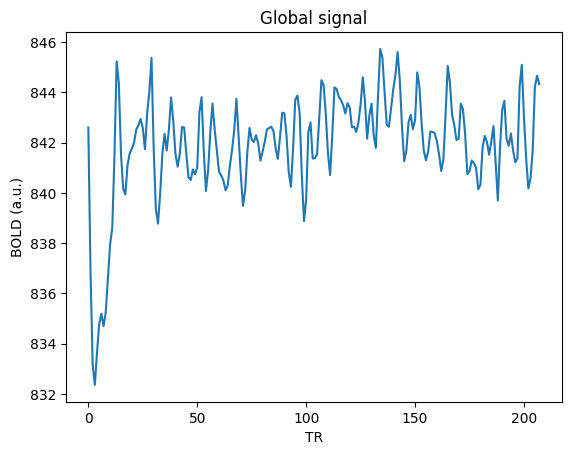

In [317]:
func_images = nl.image.load_img(bold[-1]) # choose last run where may be most motion for illustration

mean_func = nl.image.mean_img(func_images)
epi_mask = nl.masking.compute_epi_mask(mean_func)
#epi_mask.to_filename(os.path.join(fcon_out,'EPI_Mask.nii')) # save for GLM below

print("Before masking, our data has shape %s ..." % (func_images.shape,))
func_masked = masking.apply_mask(func_images, epi_mask) 
print("... and afterwards our data has shape %s and is a %s" % (func_masked.shape, type(func_masked).__name__))
global_signal = np.mean(func_masked,axis=1)

plt.figure(); plt.plot(global_signal)
ax = plt.gca(); ax.set_title('Global signal'); ax.set_ylabel('BOLD (a.u.)');  ax.set_xlabel('TR');
plt.show()

If you did want to include global signal as an additional covariate, then you could run something like:

```python
for run in range(len(confound_files)):
    global_signal = pd.read_table(confound_files[run], usecols = ["global_signal"])
    global_signal = (global_signal -  global_signal.mean()) /  global_signal.std()
    confounds_for_glm[run] = pd.concat([confounds_for_glm[run], global_signal], axis=1)
```

Carpet plot of raw data

/tmp/ipykernel_4610/1984532504.py:10: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  discrete_atlas_img = image.new_img_like(atlas_img,discrete_version) # make an image
/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/joblib/memory.py:312: UserWarning: Casting data from int32 to float32
  return self.func(*args, **kwargs)


Coercing atlas_values to <class 'int'>


/tmp/ipykernel_4610/1984532504.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


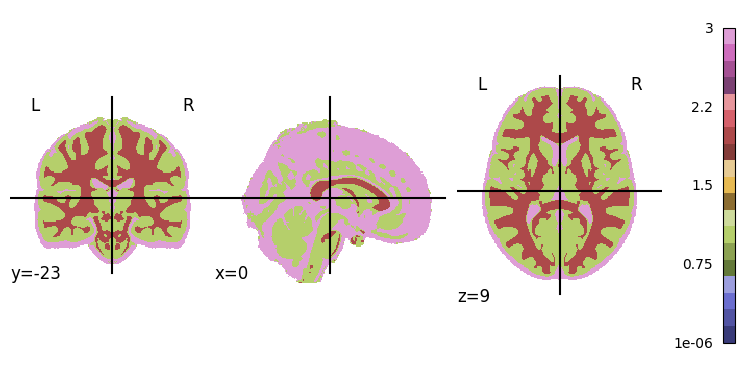

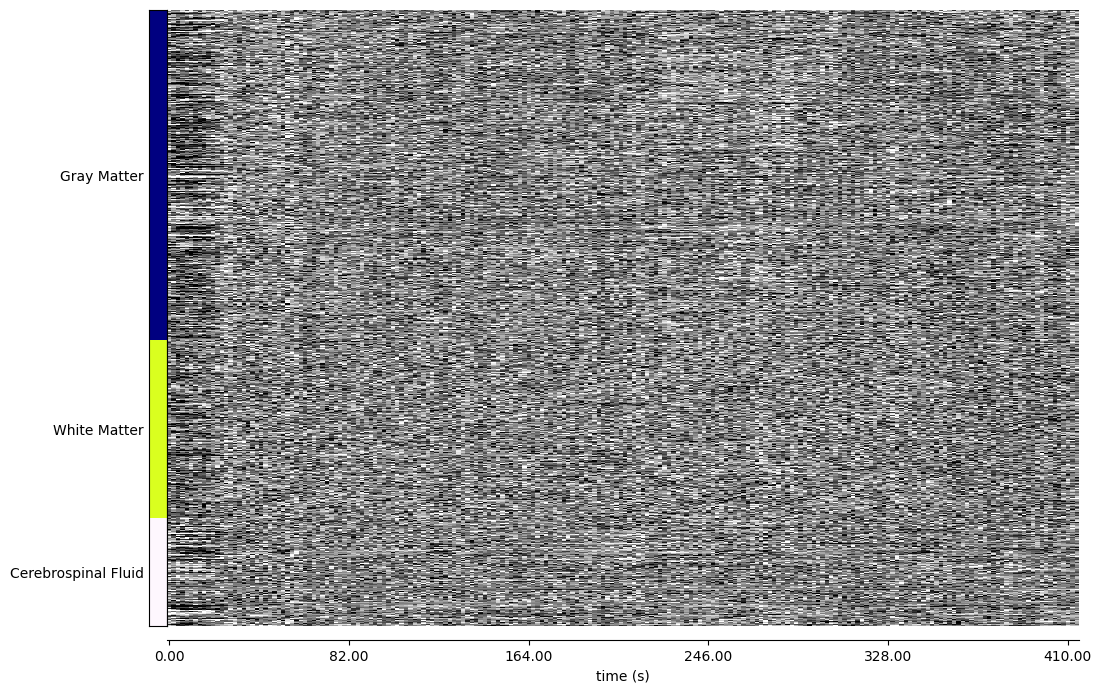

In [318]:
TR = layout.get_tr()

atlas=datasets.fetch_icbm152_2009(data_dir=fcon_out) # this downloads an atlas
atlas_img = image.concat_imgs((atlas["gm"], atlas["wm"], atlas["csf"])) # we select the Gray matter, White matter and CSF segmented images
map_labels={"Gray Matter": 1, "White Matter": 2, "Cerebrospinal Fluid": 3} # We assign them labels

atlas_data = atlas_img.get_fdata() # This is the raw image data
discrete_version = np.argmax(atlas_data, axis = 3) + 1 # we find the index of maximum value across gm,wm and csf for each voxel
discrete_version[np.max(atlas_data, axis = 3) == 0] = 0
discrete_atlas_img = image.new_img_like(atlas_img,discrete_version) # make an image

plotting.plot_stat_map(discrete_atlas_img,cmap='tab20b')

fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(
    func_images,
    discrete_atlas_img,
    t_r = TR,
    mask_labels = map_labels,
    axes = ax,
    cmap="gray")
fig.show()

This is not a particularly bad run - apart from more variance at start of run - though in runs with a lot of head motion, clear stripes can be seen.

(208, 707947)


/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/joblib/memory.py:312: UserWarning: Casting data from int32 to float32
  return self.func(*args, **kwargs)


Coercing atlas_values to <class 'int'>


/tmp/ipykernel_4610/1507954197.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


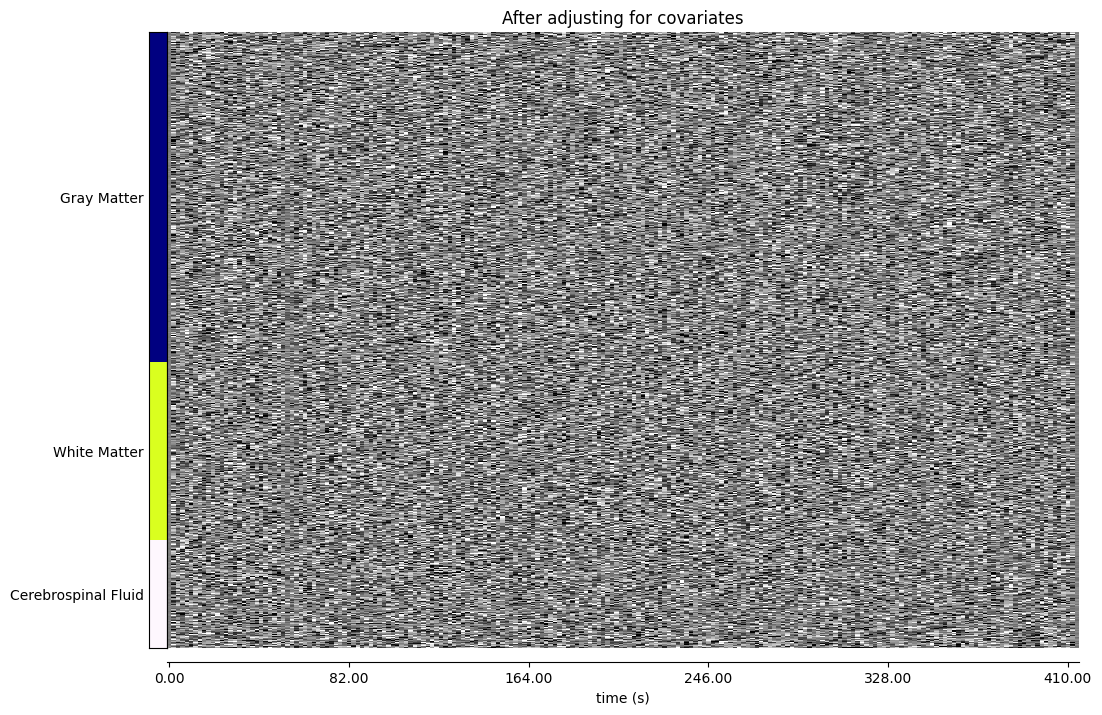

In [345]:
brain_masker = NiftiMasker(standardize='zscore', high_pass=0.008, t_r=TR)
confounds = np.asarray(confounds_for_glm[-1])

bold_data_adj_confounds = brain_masker.fit_transform(func_images, confounds = confounds)
#print(bold_data_adj_confounds.shape)

cleaned_data_confounds = brain_masker.inverse_transform(bold_data_adj_confounds) 
# Note it does not invert any signal processing done to the image - see https://nilearn.github.io/stable/manipulating_images/masker_objects.html

fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(
    cleaned_data_confounds,
    discrete_atlas_img,
    t_r = TR,
    mask_labels=map_labels,
    axes=ax,
    cmap="gray", title='After adjusting for confounds')
fig.show()

This looks a little bit cleaner (e.g. at start of run), though admit difficult to see in this particular dataset (try yours!)

But we still have responses related to the task, ie each trial that a stimulus was presented. To remove these, we need to recreate GLM and extract the regressors (note we have removed filtering and noise model)

In [ ]:
#lsa_events = []
#for run, events_file in enumerate(events_files):
#    events_df = pd.read_table(events_file)
#    for j, event in enumerate(events_df['trial_type']):
#        events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]
#    events_df = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])
#    lsa_events.append(events_df)

# Create a LSA model but now with all trials of ALL conditions
events_df = pd.read_table(events_files[-1])
for j, event in enumerate(events_df['trial_type']):
    events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]
lsa_events = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])

print(f"Using {len(lsa_events)} dfs to remove task effects")

slice_timing = layout.get_metadata(bold[-1])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR

fmri_glm = FirstLevelModel(t_r = TR,
                           slice_time_ref = slice_time_ref,
                           hrf_model = 'spm',
                           drift_model = 'cosine',
                           drift_order = None,
                           high_pass = 0,
                           smoothing_fwhm = None,
                           signal_scaling = (0, 1), # grand mean scaling only
                           noise_model = None,
                           mask_img = epi_mask,
                           memory = 'scratch');

#for run in range(len(bold)):
#    run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);

run_glm = fmri_glm.fit(bold[-1], lsa_events);
design_matrix = fmri_glm.design_matrices_
plot_design_matrix(design_matrix, output_file=None)
fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

Using 92 trial regressors, ie total of 119 from 208 TRs to remove task and confounds


/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/joblib/memory.py:312: UserWarning: Casting data from int32 to float32
  return self.func(*args, **kwargs)


Coercing atlas_values to <class 'int'>


/tmp/ipykernel_4610/3965714252.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


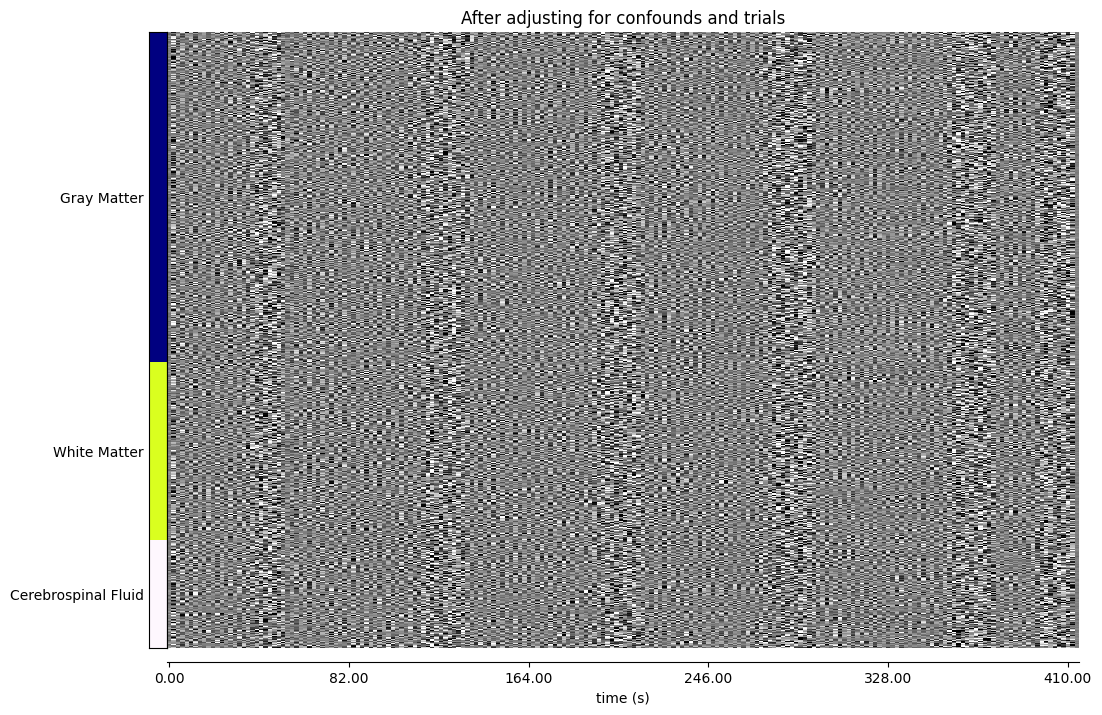

In [356]:
trial_regressors = np.asarray(design_matrix[0])
trial_regressors = trial_regressors[:,:-1] # remove constant

print(f"Using {trial_regressors.shape[1]} trial regressors, ie total of {trial_regressors.shape[1] + confounds.shape[1]} from {nvols} TRs to remove task and confounds")
bold_data_adj_all = brain_masker.fit_transform(func_images, confounds = np.concatenate([confounds, trial_regressors], axis=1))

cleaned_data_all = brain_masker.inverse_transform(bold_data_adj_all) 

fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(
    cleaned_data_all,
    discrete_atlas_img,
    t_r = TR,
    mask_labels=map_labels,
    axes=ax,
    cmap="gray", title='After adjusting for confounds and trials')
fig.show()

Now you can clearly see the blocked structure of trials, with shorter periods of rest between blocks, where variance increases